<a href="https://colab.research.google.com/github/Jinyu-Luo/CHL5230-Datathon1/blob/main/ObesityClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHL5230 Datathon 1

## Introduction

In [5]:
# Import necessary libraries
from google.colab import files
import pandas as pd
import io
import matplotlib.pyplot as plt
# !pip install matplotlib seaborn
import seaborn as sns

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# upload the data
from google.colab import files
uploaded = files.upload()

Saving CHL5230-F23-Datathon #1-Dataset1.csv to CHL5230-F23-Datathon #1-Dataset1.csv


In [93]:
df = pd.read_csv(io.BytesIO(uploaded['CHL5230-F23-Datathon #1-Dataset1.csv']))
df.head()

,Age,Gender,Calorie_Intake,Sugar_Intake,Physical_Activity,Fast_Food_Frequency,Screen_Time,Height,Weight,BMI
0,56,Female,3091,90,160,4,1,1.569070,81.199394,32.981343
1,69,Female,2090,106,27,0,9,1.629449,74.273566,27.973877
2,46,Male,2938,11,45,2,3,1.637726,71.453466,26.640417
3,32,Female,3022,48,112,1,8,1.514198,98.163045,42.813720
4,60,Female,2350,83,115,0,7,1.410559,57.323914,28.810685


The dataset consists of 23,535 observations with 10 pieces of information for each observation.

In [ ]:
# Get the shape of the dataframe
print(df.shape)

(23535, 10)


In [ ]:
# List the columns of the dataframe
print(df.columns)

Index(['Age', 'Gender', 'Calorie_Intake', 'Sugar_Intake', 'Physical_Activity',
       'Fast_Food_Frequency', 'Screen_Time', 'Height', 'Weight', 'BMI'],
      dtype='object')


#### Descriptive Statistics
Gain some insights into the statistical properties of the dataset.

In [ ]:
# Display summary statistics
print(df.describe())

                Age        Gender  Calorie_Intake  Sugar_Intake  \
count  23535.000000  23535.000000    23535.000000  23535.000000   
mean      48.532993      0.367070     2495.845634     64.824559   
std       17.872736      0.482016      577.798752     32.004657   
min       18.000000      0.000000     1500.000000     10.000000   
25%       33.000000      0.000000     1991.000000     37.000000   
50%       48.000000      0.000000     2495.000000     65.000000   
75%       64.000000      1.000000     2994.000000     93.000000   
max       79.000000      1.000000     3499.000000    119.000000   

       Physical_Activity  Fast_Food_Frequency   Screen_Time        Height  \
count       23535.000000         23535.000000  23535.000000  23535.000000   
mean           89.496707             2.018441      5.486127      1.650279   
std            52.120810             1.414634      3.454036      0.119714   
min             0.000000             0.000000      0.000000      1.196086   
25%        

#### Check Missing Values
As displayed below, there is no missing value in our dataset.

In [ ]:
print(df.isnull().sum())

Age                    0
Gender                 0
Calorie_Intake         0
Sugar_Intake           0
Physical_Activity      0
Fast_Food_Frequency    0
Screen_Time            0
Height                 0
Weight                 0
BMI                    0
dtype: int64


Below, by checking the uniqueness of entries, we found that data in `Fast_Food_Frequency` and `Screen_Time` are discrete.

In [ ]:
import numpy as np
# Check categories in fast food frequency
sorted_freq = np.sort(df['Fast_Food_Frequency'].unique())
print("\nUnique values from the Fast_Food_Freqency colum:\n", sorted_freq)


Unique values from the Fast_Food_Freqency colum:
 [0 1 2 3 4]


In [ ]:
# Check categories in screen time
sorted_screen_time = np.sort(df['Screen_Time'].unique())
print("\nUnique values from the Screen_Time colum:\n", sorted_screen_time)


Unique values from the Screen_Time colum:
 [ 0  1  2  3  4  5  6  7  8  9 10 11]


### Preprocess the Data

First, encode the categorical data. As observed above, "Gender" is the only categorical column, which comprises only two categories: Male and Female. Thus, we will encode the "Gender" column by assigning 1 to Male and 0 to Female.

In [ ]:
# Check categories in Gender column
print("\nUnique values from the Gender colum:\n", df['Gender'].unique())


Unique values from the Gender colum:
 ['Female' 'Male']


In [94]:
# Preprocess the data
# Encoding 'Gender' column
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Male: 1, Female: 0

In [75]:
# Add 'weight_status' column based on BMI
def health_status_classifier(bmi):
  if bmi < 18.5:
    return 'Underweight'
  elif 18.5 <= bmi < 25:
    return 'Normal weight'
  elif 25 <= bmi < 30:
    return 'Overweight'
  else:
    return 'Obesity'

df['status'] = df['BMI'].apply(health_status_classifier)

Check the distribution of data according to BMI categories.

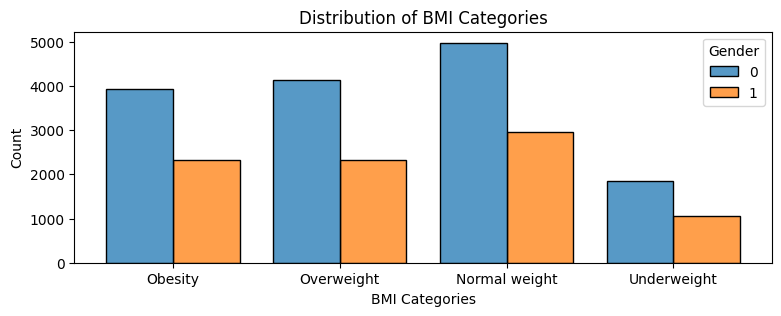

In [50]:
# Plot for the distribution of BMI Categories
plt.figure(figsize=(9,3))
sns.histplot(data = df, x = "status", hue = "Gender",
             multiple = "dodge", shrink = .8)
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Categories')
plt.ylabel("Count")
plt.show()

Note that the proportion of underweight people are much less than proportions of the other categories. If we just perfrom a random train-test split, it might result in very different data distributions in the training and test sets. Therefore, we will address this issue by stratifying the BMI categories during the data spliting step.

Since BMI is calculated based on height and weight and we have categorized people into different BMI categories, we will remove height, weight, and BMI from the dataframe for the following analysis.

## Data Engineering Process

### Data Preparation

In [92]:
from imblearn.over_sampling import SMOTE

In [77]:
# Split the dataset by gender
male_data = df[df['Gender'] == 1]
female_data = df[df['Gender'] == 0]

def prepare_data(data):
  # split the data into features and label
  X = data[['Age', 'Calorie_Intake', 'Sugar_Intake', 'Physical_Activity',
        'Fast_Food_Frequency', 'Screen_Time']]
  y = data['status']

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state=42)

  # Apply SMOTE on the training data set only
  smote = SMOTE(random_state = 42)
  X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

  # Scale the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_smt)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled, y_train_smt, y_test

# Prepare data for males and females
X_train_male, X_test_male, y_train_male, y_test_male = prepare_data(male_data)
X_train_female, X_test_female, y_train_female, y_test_female = prepare_data(female_data)

### Train the KNN Classifier

In [89]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=100)  # Setting K to 5 as an example

# Hyperparameters to tune
param_grid = {
    'n_neighbors': [5, 10, 20, 30, 40, 50, 75, 100], # number of neighbors
    'weights': ['uniform', 'distance'], # weight function used for prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'], # distance matric
    'p': [1, 2] # Power parameter for the Minkowski metric. 1 is manhattan_distance and 2 is euclidean_distance.
}

# Use GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(estimator = knn,
                               param_grid = param_grid,
                               cv = 3, n_jobs = -1, verbose = 2,
                               scoring = 'accuracy')

# Train and predict the male data
knn_grid_search.fit(X_train_male, y_train_male)
print("Best Parameters: ", knn_grid_search.best_params_)
y_pred_male = knn_grid_search.best_estimator_.predict(X_test_male)
print("Classification Report for Males:")
print(classification_report(y_test_male, y_pred_male))

# Train and predict the female data
knn_grid_search.fit(X_train_female, y_train_female)
print("Best Parameters: ", knn_grid_search.best_params_)
y_pred_female = knn_grid_search.best_estimator_.predict(X_test_female)
print("Classification Report for Males:")
print(classification_report(y_test_female, y_pred_female))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Classification Report for Males:
               precision    recall  f1-score   support

Normal weight       0.37      0.28      0.32       587
      Obesity       0.28      0.28      0.28       462
   Overweight       0.31      0.27      0.29       479
  Underweight       0.11      0.21      0.14       200

     accuracy                           0.27      1728
    macro avg       0.27      0.26      0.26      1728
 weighted avg       0.30      0.27      0.28      1728

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Classification Report for Males:
               precision    recall  f1-score   support

Normal weight       0.35      0.26      0.30       988
      Obesity       0.25      0.24      0.24       814
   Overweight      

The accuracy is relative low for both genders, and the performance for each class is not very high. This result indicate that the features are not providing a clear boundary for KNN.

### Train Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [68]:
# Initialize a Random Forest Classifier
rf = RandomForestClassifier(random_state = 42)

# Hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200], # number of trees
    'max_depth': [None, 10, 20, 30], # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # minimum number of samples required to be at a leaf node
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 2,
                           scoring = 'accuracy')

# Fit the model
grid_search.fit(X_train_male, y_train_male) # for males
print("Best Parameters for males: ", grid_search.best_params_)

grid_search.fit(X_train_female, y_train_female) # for females
print("Best Parameters for females: ", grid_search.best_params_)

# Predict on the test data
y_pred_males = grid_search.best_estimator_.predict(X_test_male)
print(classification_report(y_test_male, y_pred_males))
y_pred_females = grid_search.best_estimator_.predict(X_test_female)
print(classification_report(y_test_female, y_pred_females))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for males:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for females:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
               precision    recall  f1-score   support

Normal weight       0.32      0.31      0.31       589
      Obesity       0.26      0.26      0.26       465
   Overweight       0.27      0.24      0.26       463
  Underweight       0.11      0.16      0.13       211

     accuracy                           0.26      1728
    macro avg       0.24      0.24      0.24      1728
 weighted avg       0.27      0.26      0.26      1728

               precision    recall  f1-score   support

Normal weight       0.35      0.35      0.35       995
      Obesity       0.26      0.26      0.26       787
   Overweight       0.31      0.2

## Obesity Classification

Due to the imbalance of the distribution of BMI category, we decided to re-label observations with a new indicator, i.e., obesity. A BMI value that is greater than or equal to 25 will be labeled as "1", meaning overweight or high risk obesity. A BMI value that is less than 25 will be labeled as "0", meaning normal in weight or underweight.  

In [95]:
def obesity(bmi):
  if bmi < 25:
    return '0' # underweight and normal
  else:
    return '1' # obese/overwight, high risk

df['obesity'] = df['BMI'].apply(obesity)

In [98]:
# Split the dataset by gender
male_data = df[df['Gender'] == 1]
female_data = df[df['Gender'] == 0]

In [100]:
# Data preparation of obesity
def obesity_data(data):
  # split the data into features and label
  X = data[['Age', 'Calorie_Intake', 'Sugar_Intake', 'Physical_Activity',
        'Fast_Food_Frequency', 'Screen_Time']]
  y = data['obesity']

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state=42)

  # Apply SMOTE on the training data set only
  smote = SMOTE(random_state = 42)
  X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

  # Scale the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_smt)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_test_scaled, y_train_smt, y_test

# Prepare data for males and females
X_train_male, X_test_male, y_train_male, y_test_male = obesity_data(male_data)
X_train_female, X_test_female, y_train_female, y_test_female = obesity_data(female_data)

In [101]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=100)  # Setting K to 5 as an example

# Hyperparameters to tune
param_grid = {
    'n_neighbors': [5, 10, 20, 30, 40, 50, 75, 100], # number of neighbors
    'weights': ['uniform', 'distance'], # weight function used for prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'], # distance matric
    'p': [1, 2] # Power parameter for the Minkowski metric. 1 is manhattan_distance and 2 is euclidean_distance.
}

# Use GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(estimator = knn,
                               param_grid = param_grid,
                               cv = 3, n_jobs = -1, verbose = 2,
                               scoring = 'accuracy')

# Train and predict the male data
knn_grid_search.fit(X_train_male, y_train_male)
print("Best Parameters: ", knn_grid_search.best_params_)
y_pred_male = knn_grid_search.best_estimator_.predict(X_test_male)
print("Classification Report for Males:")
print(classification_report(y_test_male, y_pred_male))

# Train and predict the female data
knn_grid_search.fit(X_train_female, y_train_female)
print("Best Parameters: ", knn_grid_search.best_params_)
y_pred_female = knn_grid_search.best_estimator_.predict(X_test_female)
print("Classification Report for Females:")
print(classification_report(y_test_female, y_pred_female))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Classification Report for Males:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47       787
           1       0.55      0.52      0.53       941

    accuracy                           0.50      1728
   macro avg       0.50      0.50      0.50      1728
weighted avg       0.51      0.50      0.51      1728

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Classification Report for Males:
              precision    recall  f1-score   support

           0       0.44      0.48      0.46      1325
           1       0.55      0.52      0.54      1655

    accuracy                           0.50      2980
   macro avg       0.50      0.50      0.50      2980
weighted avg       0.51      

In [102]:
# Initialize a Random Forest Classifier
rf = RandomForestClassifier(random_state = 42)

# Hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200], # number of trees
    'max_depth': [None, 10, 20, 30], # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # minimum number of samples required to be at a leaf node
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 2,
                           scoring = 'accuracy')

# Fit the model
grid_search.fit(X_train_male, y_train_male) # for males
print("Best Parameters for males: ", grid_search.best_params_)

grid_search.fit(X_train_female, y_train_female) # for females
print("Best Parameters for females: ", grid_search.best_params_)

# Predict on the test data
y_pred_males = grid_search.best_estimator_.predict(X_test_male)
print(classification_report(y_test_male, y_pred_males))
y_pred_females = grid_search.best_estimator_.predict(X_test_female)
print(classification_report(y_test_female, y_pred_females))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for males:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for females:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       787
           1       0.55      0.52      0.54       941

    accuracy                           0.50      1728
   macro avg       0.50      0.50      0.50      1728
weighted avg       0.51      0.50      0.51      1728

              precision    recall  f1-score   support

           0       0.44      0.44      0.44      1325
           1       0.55      0.54      0.55      1655

    accuracy                           0.50      2980
   macro avg       0.49      0.49      0.49      2980
weighted avg       0.50      0.50      0.50  